# Projeto – Etapa 1: Pré-processamento de Dados para Manutenção Preditiva na Indústria 4.0
## Introdução
Neste projeto, simularemos o papel de um engenheiro/cientista de dados no pré-processamento de um dataset de telemetria de máquinas para um sistema de manutenção preditiva. O objetivo é limpar, transformar e enriquecer os dados, tornando-os aptos para a construção de modelos preditivos.

In [1]:
#Passo 1: Carregamento e Entendimento Inicial do Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Carregar o dataset
try:
    df = pd.read_csv('ai4i2020.csv')
    print("Dataset 'ai4i2020.csv' carregado com sucesso!")
except FileNotFoundError:
    print("Erro: O arquivo 'ai4i2020.csv' não foi encontrado. Por favor, certifique-se de que o arquivo está no diretório correto ou execute os comandos de download/descompressão no Colab.")
    # Se o arquivo não for encontrado, o restante do script não poderá ser executado
    exit() # Interrompe a execução para evitar erros posteriores

print("\n--- Primeiras 5 linhas do Dataset ---")
print(df.head())

print("\n--- Informações Gerais do Dataset (.info()) ---")
df.info()

print("\n--- Dimensões do Dataset (.shape) ---")
print(f"Linhas: {df.shape[0]}, Colunas: {df.shape[1]}")

print("\n--- Estatísticas Descritivas das Colunas Numéricas (.describe()) ---")
print(df.describe())

print("\n--- Verificação de Valores Ausentes (.isnull().sum()) ---")
print(df.isnull().sum())

print("\n--- Verificação de Unicidade das Colunas de Identificação ---")
print(f"UDI - Valores únicos: {df['UDI'].nunique()}, Total de linhas: {df.shape[0]}")
print(f"UDI - Há valores duplicados? {df['UDI'].duplicated().any()}")
print(f"Product ID - Valores únicos: {df['Product ID'].nunique()}, Total de linhas: {df.shape[0]}")
print(f"Product ID - Há valores duplicados? {df['Product ID'].duplicated().any()}")

if df['UDI'].duplicated().any() or df['Product ID'].duplicated().any():
    print("\n[Observação] Existem valores duplicados em uma ou ambas as colunas de identificação. Isso pode ser problemático se cada linha deveria representar uma entrada única.")
else:
    print("\n[Observação] Não foram encontrados valores duplicados nas colunas 'UDI' ou 'Product ID'.")

Dataset 'ai4i2020.csv' carregado com sucesso!

--- Primeiras 5 linhas do Dataset ---
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0

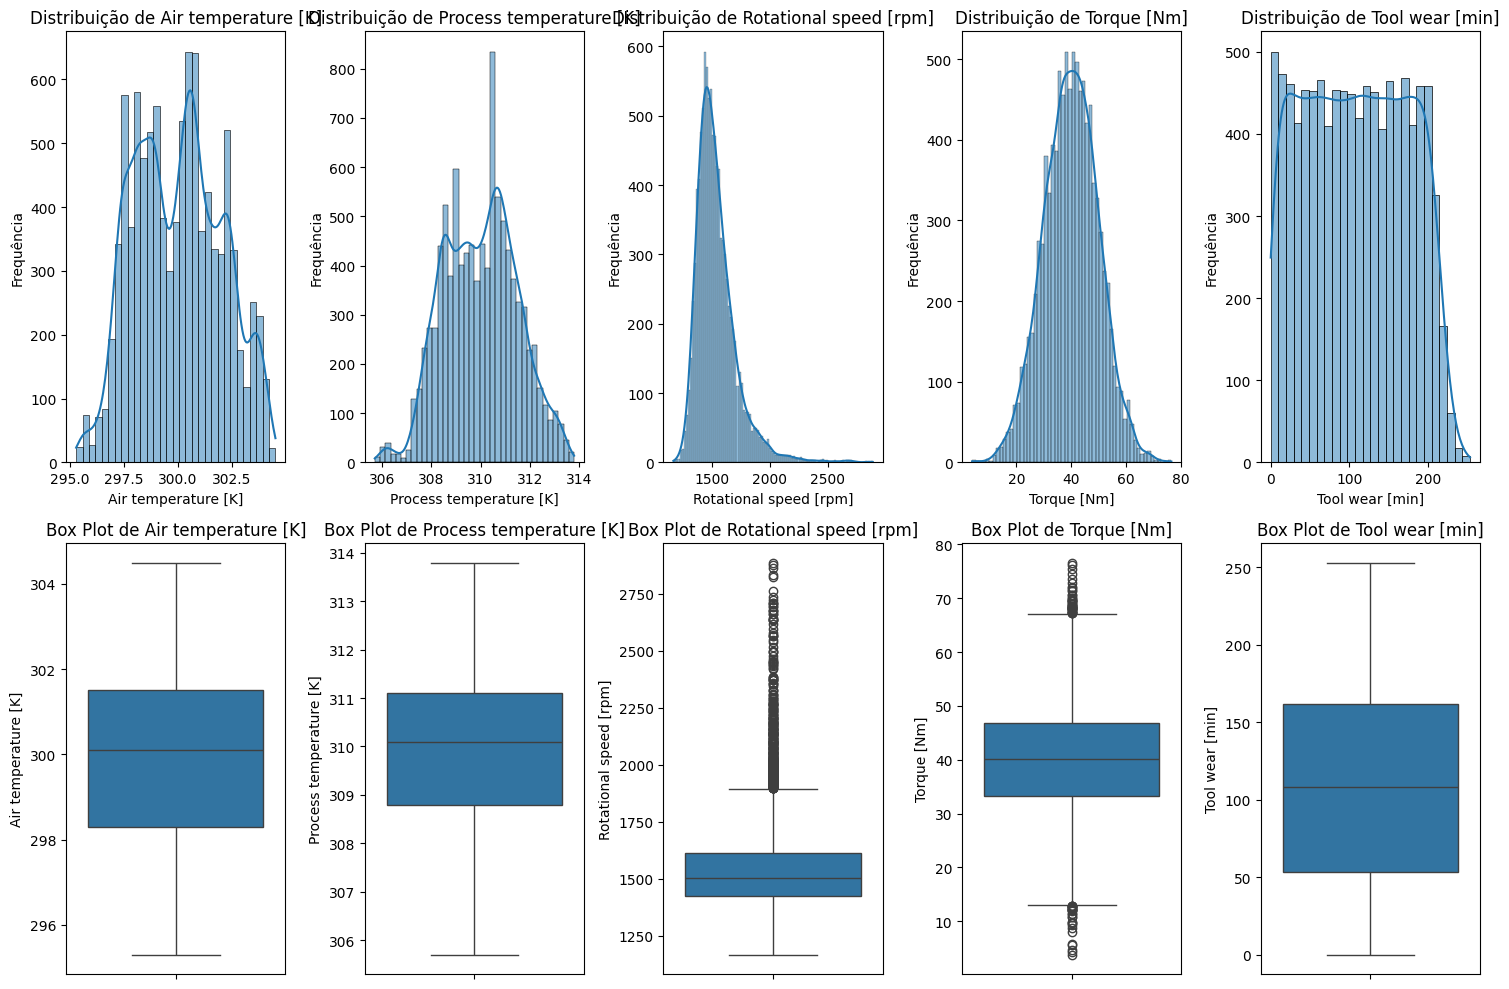

In [2]:
#Passo 2: Análise Exploratória de Dados (EDA) Detalhada
"""Distribuição das Variáveis Numéricas
Vamos criar histogramas e box plots para as variáveis numéricas para entender suas distribuições, simetria e a presença de outliers."""
# Lista de colunas numéricas para análise
numerical_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    # Histograma
    plt.subplot(2, len(numerical_cols), i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')

    # Box Plot
    plt.subplot(2, len(numerical_cols), i + 1 + len(numerical_cols))
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot de {col}')
    plt.ylabel(col)
plt.tight_layout()
plt.show()


[STATUS] Coluna 'Machine failure' renomeada para 'Target'.

[STATUS] Coluna 'Failure Type' criada a partir de TWF, HDF, PWF, OSF, RNF.

Verificando casos onde múltiplas falhas são 1 (se houver):
Foram encontradas 24 linhas onde múltiplas falhas são 1. A coluna 'Failure Type' irá capturar a primeira encontrada na ordem: ['TWF', 'HDF', 'PWF', 'OSF', 'RNF'].

--- Nomes das Colunas Após Renomeação e Criação ---
['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'Target', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Failure Type']

--- Contagem de Valores para 'Type' ---
Type
L    6000
M    2997
H    1003
Name: count, dtype: int64


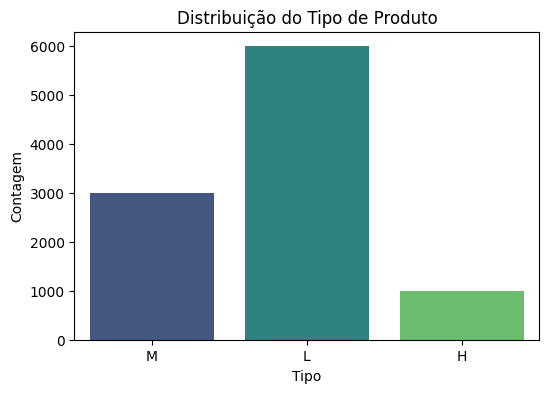


--- Contagem de Valores para 'Target' (0=sem falha, 1=falha) ---
Target
0    9661
1     339
Name: count, dtype: int64


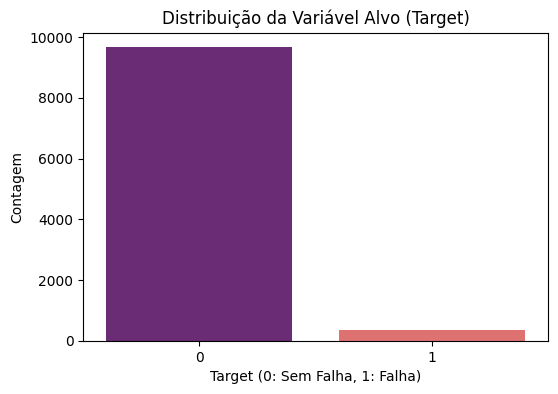


--- Contagem de Valores para 'Failure Type' ---
Failure Type
No Failure         9661
HDF                 115
PWF                  91
OSF                  78
TWF                  46
Unknown Failure       9
Name: count, dtype: int64


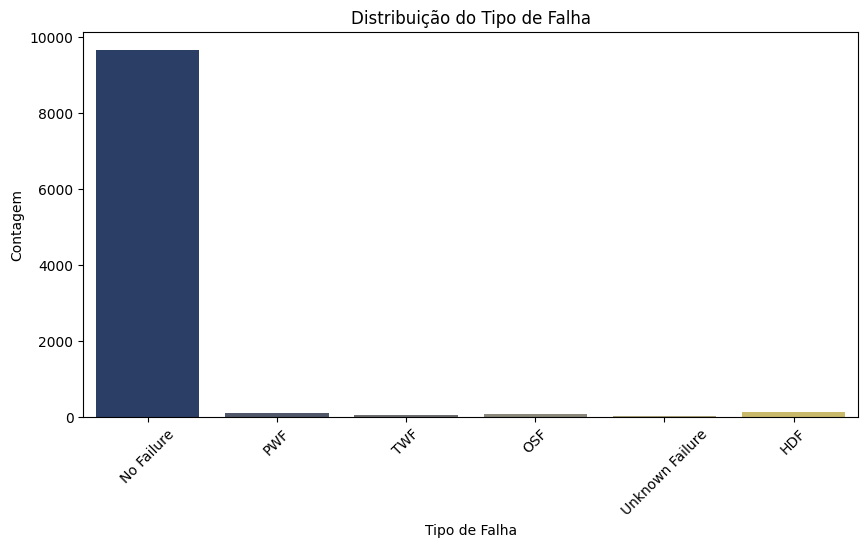

In [3]:
"""Análise de Variáveis Categóricas
Vamos inspecionar as distribuições das variáveis categóricas Type, Target e Failure Type."""
# 1. Definir a coluna 'Target'
# Renomear 'Machine failure' para 'Target'
if 'Machine failure' in df.columns:
    df.rename(columns={'Machine failure': 'Target'}, inplace=True)
    print("\n[STATUS] Coluna 'Machine failure' renomeada para 'Target'.")
else:
    print("\n[ERRO FATAL] A coluna 'Machine failure' não foi encontrada. Verifique o nome exato da coluna no seu CSV. Não é possível definir 'Target'.")
    exit()

# 2. Criar a coluna 'Failure Type' a partir das colunas binárias de falha
failure_type_cols = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

# Verificar se todas as colunas de tipo de falha existem
if not all(col in df.columns for col in failure_type_cols):
    print("\n[AVISO] Nem todas as colunas de tipo de falha (TWF, HDF, PWF, OSF, RNF) foram encontradas.")
    print("A coluna 'Failure Type' pode não ser criada corretamente ou será limitada às colunas existentes.")
    # Ajustar failure_type_cols para conter apenas as colunas que realmente existem
    failure_type_cols = [col for col in failure_type_cols if col in df.columns]
    if not failure_type_cols:
        print("[AVISO] Nenhuma coluna de tipo de falha específica foi encontrada. 'Failure Type' não será criada.")
        df['Failure Type'] = 'No Failure' # Define um valor padrão se não houver colunas de falha
    else:
        print(f"Usando as seguintes colunas para 'Failure Type': {failure_type_cols}")

if 'Failure Type' not in df.columns: # Só cria se não existir (evita recriar se já foi criada por outro motivo)
    def get_failure_type(row):
        if row['Target'] == 0:
            return 'No Failure'
        for col in failure_type_cols:
            if row[col] == 1:
                return col # Retorna o nome da coluna que é 1
        return 'Unknown Failure' # Caso Target seja 1 mas nenhuma das colunas de falha seja 1

    # Aplicar a função para criar a nova coluna 'Failure Type'
    df['Failure Type'] = df.apply(get_failure_type, axis=1)
    print("\n[STATUS] Coluna 'Failure Type' criada a partir de TWF, HDF, PWF, OSF, RNF.")
    print("\nVerificando casos onde múltiplas falhas são 1 (se houver):")
    # Contar linhas onde mais de uma coluna de falha é 1
    multiple_failures = df[df[failure_type_cols].sum(axis=1) > 1]
    if not multiple_failures.empty:
        print(f"Foram encontradas {len(multiple_failures)} linhas onde múltiplas falhas são 1. A coluna 'Failure Type' irá capturar a primeira encontrada na ordem: {failure_type_cols}.")
    else:
        print("Nenhuma linha encontrada com múltiplas falhas ativas simultaneamente.")

print("\n--- Nomes das Colunas Após Renomeação e Criação ---")
print(df.columns.tolist())


print("\n--- Contagem de Valores para 'Type' ---")
if 'Type' in df.columns:
    print(df['Type'].value_counts())
    plt.figure(figsize=(6, 4))
    # Correção: Adicionar hue='Type' e legend=False
    sns.countplot(x='Type', data=df, palette='viridis', hue='Type', legend=False)
    plt.title('Distribuição do Tipo de Produto')
    plt.xlabel('Tipo')
    plt.ylabel('Contagem')
    plt.show()
else:
    print("[AVISO] Coluna 'Type' não encontrada para análise. Verifique o nome da coluna.")


print("\n--- Contagem de Valores para 'Target' (0=sem falha, 1=falha) ---")
print(df['Target'].value_counts())
plt.figure(figsize=(6, 4))
# Correção: Adicionar hue='Target' e legend=False
sns.countplot(x='Target', data=df, palette='magma', hue='Target', legend=False)
plt.title('Distribuição da Variável Alvo (Target)')
plt.xlabel('Target (0: Sem Falha, 1: Falha)')
plt.ylabel('Contagem')
plt.show()


print("\n--- Contagem de Valores para 'Failure Type' ---")
print(df['Failure Type'].value_counts())
plt.figure(figsize=(10, 5))
# Correção: Adicionar hue='Failure Type' e legend=False
sns.countplot(x='Failure Type', data=df, palette='cividis', hue='Failure Type', legend=False)
plt.title('Distribuição do Tipo de Falha')
plt.xlabel('Tipo de Falha')
plt.ylabel('Contagem')
plt.xticks(rotation=45)
plt.show()


--- Scatter Plots entre Variáveis Numéricas Relevantes ---


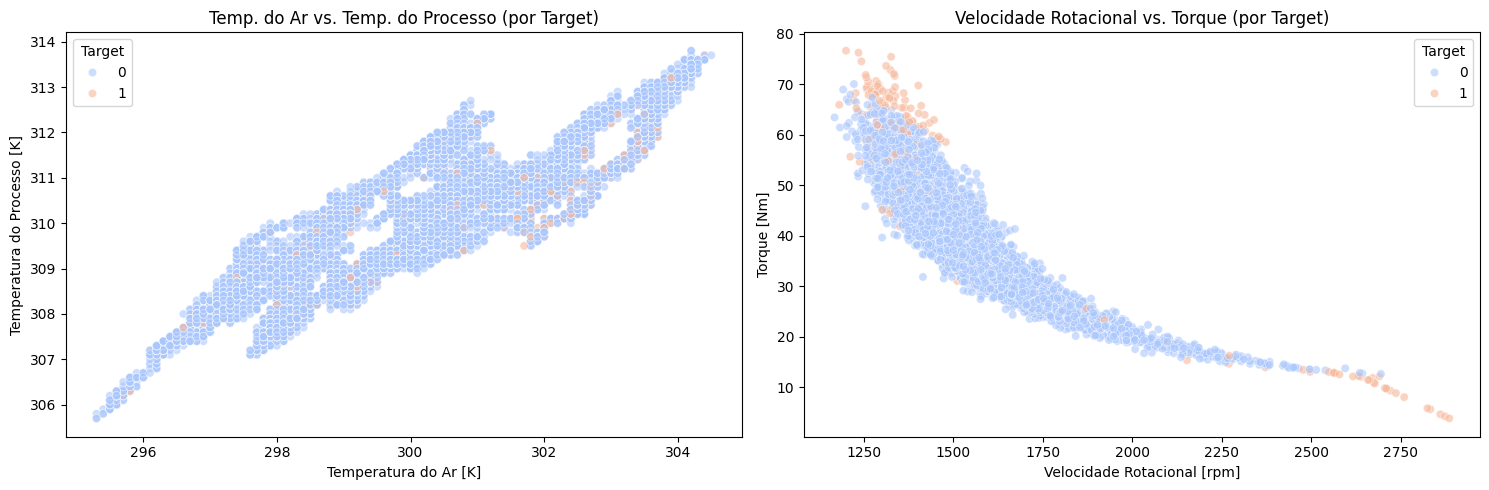


--- Matriz de Correlação entre Variáveis Numéricas ---


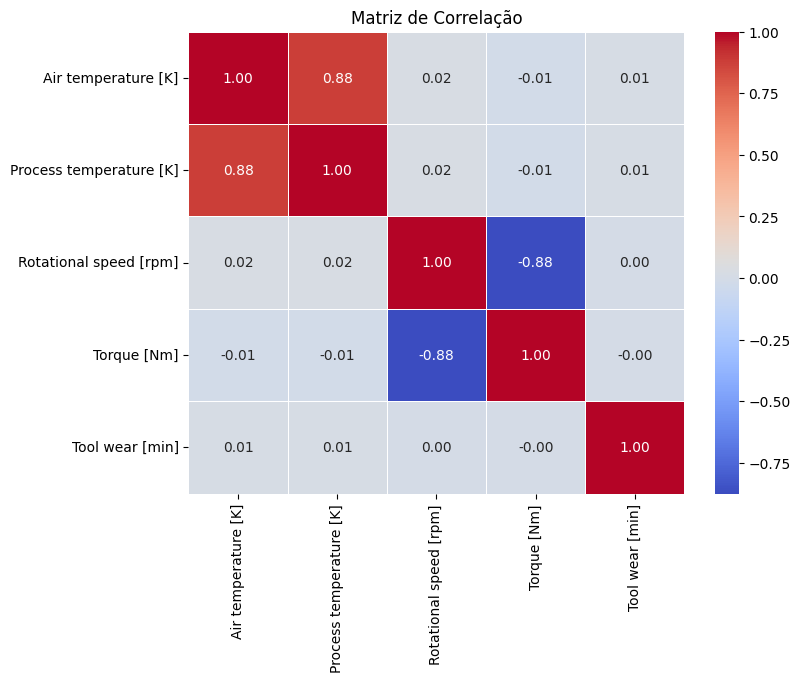


--- Box Plots de Temperatura vs. Tipo de Produto ---


/tmp/ipython-input-4-2840755981.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Air temperature [K]', data=df, palette='Pastel1')
/tmp/ipython-input-4-2840755981.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Type', y='Process temperature [K]', data=df, palette='Pastel2')


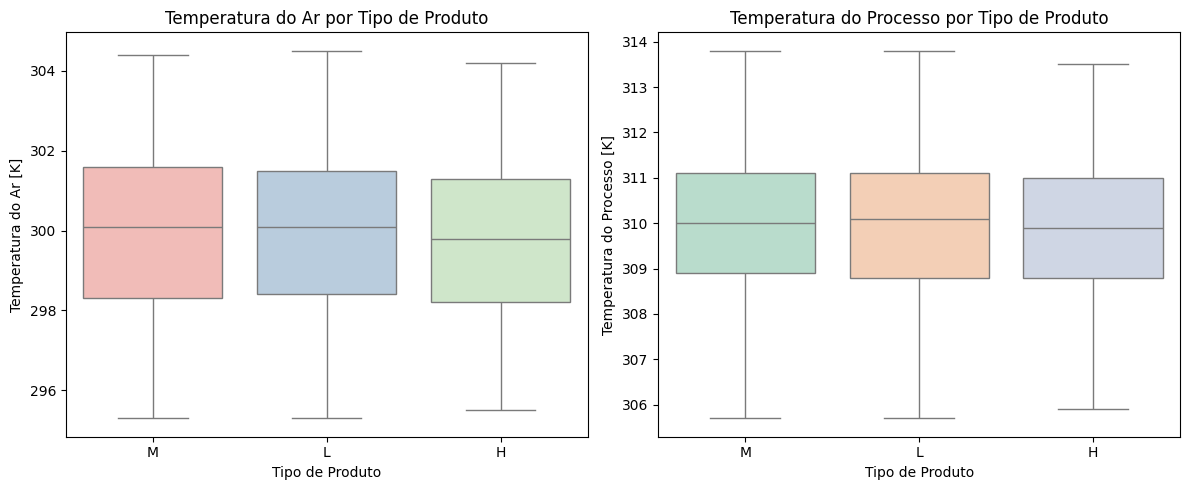

In [4]:
"""Relação entre Variáveis
Vamos investigar as relações entre as variáveis numéricas e como as variáveis numéricas se comportam para diferentes categorias."""
# Scatter plots entre pares de variáveis numéricas relevantes
print("\n--- Scatter Plots entre Variáveis Numéricas Relevantes ---")
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.scatterplot(x='Air temperature [K]', y='Process temperature [K]', data=df, hue='Target', palette='coolwarm', alpha=0.6)
plt.title('Temp. do Ar vs. Temp. do Processo (por Target)')
plt.xlabel('Temperatura do Ar [K]')
plt.ylabel('Temperatura do Processo [K]')

plt.subplot(1, 2, 2)
sns.scatterplot(x='Rotational speed [rpm]', y='Torque [Nm]', data=df, hue='Target', palette='coolwarm', alpha=0.6)
plt.title('Velocidade Rotacional vs. Torque (por Target)')
plt.xlabel('Velocidade Rotacional [rpm]')
plt.ylabel('Torque [Nm]')
plt.tight_layout()
plt.show()

# Matriz de Correlação
print("\n--- Matriz de Correlação entre Variáveis Numéricas ---")
correlation_matrix = df[numerical_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

# Box plots de temperatura vs Type
print("\n--- Box Plots de Temperatura vs. Tipo de Produto ---")
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(x='Type', y='Air temperature [K]', data=df, palette='Pastel1')
plt.title('Temperatura do Ar por Tipo de Produto')
plt.xlabel('Tipo de Produto')
plt.ylabel('Temperatura do Ar [K]')

plt.subplot(1, 2, 2)
sns.boxplot(x='Type', y='Process temperature [K]', data=df, palette='Pastel2')
plt.title('Temperatura do Processo por Tipo de Produto')
plt.xlabel('Tipo de Produto')
plt.ylabel('Temperatura do Processo [K]')
plt.tight_layout()
plt.show()

# Passo 3: Pré-processamento de Dados
## 1. Tratamento de Valores Ausentes
Problema Identificado: Como observado no Passo 1, o dataset ai4i2020.csv não possui valores ausentes.

Técnica Escolhida: Nenhuma imputação ou remoção é necessária neste caso.

In [6]:
print("\n--- Tratamento de Valores Ausentes ---")
print("Valores ausentes antes do tratamento:\n", df.isnull().sum())
# Não há valores ausentes, então nenhuma ação é necessária aqui.
print("\n[Status] Nenhuma ação necessária: O dataset não possui valores ausentes.")


--- Tratamento de Valores Ausentes ---
Valores ausentes antes do tratamento:
 UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Target                     0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
Failure Type               0
dtype: int64

[Status] Nenhuma ação necessária: O dataset não possui valores ausentes.


## 2. Identificação e Tratamento de Outliers
### Problema Identificado:
Os box plots da EDA (Passo 2) indicaram a presença de outliers em várias colunas numéricas (Air temperature [K], Process temperature [K], Rotational speed [rpm], Torque [Nm], Tool wear [min]).

### Técnica Escolhida:
Aplicaremos a técnica de Capping (Clipping). Limitaremos os valores extremos das colunas numéricas aos percentis de 1% e 99%.

### Justificativa para a Escolha:

  A remoção de outliers pode resultar em perda de dados valiosos, especialmente em datasets onde outliers podem representar eventos de falha importantes (mesmo que raros).

  A transformação logarítmica ou de raiz quadrada é útil para distribuições muito assimétricas, mas para as nossas colunas, que já têm uma forma razoável, o capping é uma abordagem mais conservadora que retém a maioria dos dados enquanto mitiga o impacto de valores excessivamente extremos, que poderiam distorcer modelos baseados em distância.

  O capping é eficaz para reduzir a influência de outliers sem descartar totalmente as observações, o que é crucial em contextos onde o volume de dados é importante ou onde os outliers podem conter informações relevantes sobre condições anormais.

### Impacto da Transformação:
 Os valores numéricos extremos serão ajustados para o limite superior ou inferior dos percentis definidos, tornando a distribuição dos dados menos suscetível a distorções causadas por outliers excessivos.


--- Identificação e Tratamento de Outliers (Capping) ---
Coluna 'Air temperature [K]': Valores abaixo de 295.90 e acima de 304.10 foram ajustados.
Coluna 'Process temperature [K]': Valores abaixo de 306.60 e acima de 313.20 foram ajustados.
Coluna 'Rotational speed [rpm]': Valores abaixo de 1275.00 e acima de 2188.01 foram ajustados.
Coluna 'Torque [Nm]': Valores abaixo de 16.70 e acima de 62.80 foram ajustados.
Coluna 'Tool wear [min]': Valores abaixo de 0.00 e acima de 222.00 foram ajustados.

[Status] Outliers tratados com Capping (1% e 99% percentis) nas colunas numéricas.


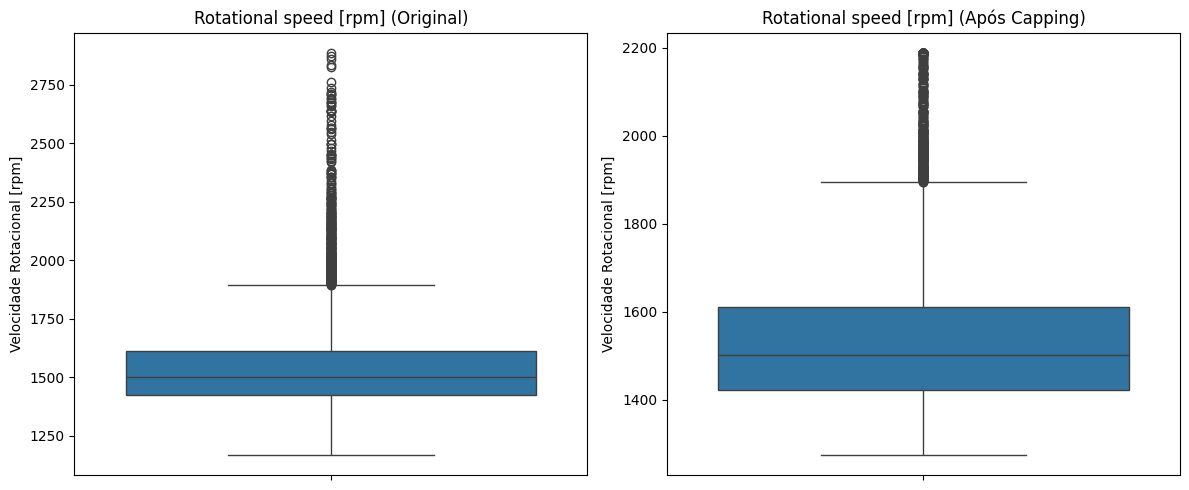

In [7]:
print("\n--- Identificação e Tratamento de Outliers (Capping) ---")

# Colunas numéricas para tratamento de outliers
numerical_cols_for_outliers = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

df_processed = df.copy() # Criar uma cópia para aplicar as transformações

for col in numerical_cols_for_outliers:
    lower_bound = df_processed[col].quantile(0.01)
    upper_bound = df_processed[col].quantile(0.99)
    df_processed[col] = np.clip(df_processed[col], lower_bound, upper_bound)
    print(f"Coluna '{col}': Valores abaixo de {lower_bound:.2f} e acima de {upper_bound:.2f} foram ajustados.")

print("\n[Status] Outliers tratados com Capping (1% e 99% percentis) nas colunas numéricas.")

# Visualização para comparar antes e depois (apenas para uma coluna de exemplo)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df['Rotational speed [rpm]'])
plt.title('Rotational speed [rpm] (Original)')
plt.ylabel('Velocidade Rotacional [rpm]')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_processed['Rotational speed [rpm]'])
plt.title('Rotational speed [rpm] (Após Capping)')
plt.ylabel('Velocidade Rotacional [rpm]')
plt.tight_layout()
plt.show()

## 3. Codificação de Variáveis Categóricas
### Problema Identificado:
A coluna Type é uma variável categórica nominal (L, M, H) que precisa ser convertida em formato numérico para ser utilizada por modelos de Machine Learning.

### Técnica Escolhida:
Aplicaremos OneHotEncoder à coluna Type.

### Justificativa para a Escolha:

OneHotEncoder é a escolha apropriada para variáveis categóricas nominais, pois cria novas colunas binárias para cada categoria, evitando que o modelo infira uma ordem ou magnitude inexistente entre as categorias (ex: L < M < H). Isso é crucial porque os tipos de produto (L, M, H) não possuem uma ordem intrínseca.

Colunas UDI e Product ID: Estas são colunas de identificação únicas. Elas não deveriam ser usadas como features em um modelo de Machine Learning.

Por quê? Incluir IDs únicos como features faria com que o modelo "memorizasse" instâncias específicas em vez de aprender padrões generalizáveis. Isso levaria a um alto overfitting e um desempenho ruim em dados novos/não vistos. Para manutenção preditiva, queremos que o modelo aprenda características de máquinas em geral que levam a falhas, não que uma máquina específica falhou no passado. Portanto, elas serão descartadas antes do treinamento do modelo.

### Impacto da Transformação:
 A coluna Type será substituída por três novas colunas binárias (Type_H, Type_L, Type_M), onde cada uma indicará a presença (1) ou ausência (0) daquele tipo.

In [8]:
print("\n--- Codificação de Variáveis Categóricas (OneHotEncoder para 'Type') ---")

# Criar uma cópia para as transformações
df_encoded = df_processed.copy()

# A coluna 'Failure Type' também é categórica, mas como a 'Target' já indica falha ou não,
# e 'Failure Type' só é relevante se 'Target' for 1, para este projeto focaremos em 'Type'.
# No entanto, se quisermos prever o TIPO de falha, 'Failure Type' seria a variável alvo,
# e 'No Failure' precisaria ser tratada. Para previsão binária de falha (Target),
# 'Failure Type' pode ser descartada ou usada para engenharia de features.
# Para a etapa 1, vamos focar em Target.

# Colunas para OneHotEncoder
categorical_cols = ['Type']

# Inicializar o OneHotEncoder
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False) # sparse_output=False para obter um array denso

# Ajustar e transformar a coluna 'Type'
encoded_features = one_hot_encoder.fit_transform(df_encoded[categorical_cols])

# Criar um DataFrame com as novas colunas codificadas
encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_cols)
df_encoded_features = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df_encoded.index)

# Concatenar o DataFrame original (sem a coluna 'Type' original) com as novas colunas
df_encoded = pd.concat([df_encoded.drop(columns=categorical_cols), df_encoded_features], axis=1)

print(f"\n[Status] Coluna '{categorical_cols[0]}' codificada com OneHotEncoder.")
print("Novas colunas criadas:", encoded_feature_names)
print("\nPrimeiras linhas do dataset após OneHotEncoding de 'Type':")
print(df_encoded.head())

# Descartar UDI e Product ID - Não são features para o modelo
df_final = df_encoded.drop(columns=['UDI', 'Product ID', 'Failure Type']) # Também descartamos Failure Type para o modelo de previsão binária Target

print("\n[Status] Colunas 'UDI', 'Product ID' e 'Failure Type' descartadas.")
print("\nPrimeiras linhas do dataset após descarte de IDs e Failure Type:")
print(df_final.head())


--- Codificação de Variáveis Categóricas (OneHotEncoder para 'Type') ---

[Status] Coluna 'Type' codificada com OneHotEncoder.
Novas colunas criadas: ['Type_H' 'Type_L' 'Type_M']

Primeiras linhas do dataset após OneHotEncoding de 'Type':
   UDI Product ID  Air temperature [K]  Process temperature [K]  \
0    1     M14860                298.1                    308.6   
1    2     L47181                298.2                    308.7   
2    3     L47182                298.1                    308.5   
3    4     L47183                298.2                    308.6   
4    5     L47184                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Target  TWF  HDF  \
0                  1551.0         42.8                0       0    0    0   
1                  1408.0         46.3                3       0    0    0   
2                  1498.0         49.4                5       0    0    0   
3                  1433.0         39.5           

## 4. Padronização/Normalização (Scaling) das Variáveis Numéricas
### Problema Identificado:
Variáveis numéricas como temperatura, velocidade e torque possuem diferentes escalas e unidades. Modelos de Machine Learning baseados em distância (ex: KNN, SVM, redes neurais) ou em otimização baseada em gradiente (ex: Regressão Logística, SVM, Redes Neurais) podem ser sensíveis a essas diferenças de escala, atribuindo maior importância a variáveis com maior amplitude de valores.

### Técnica Escolhida:
 Escolheremos o StandardScaler.

### Justificativa para a Escolha:

### StandardScaler:
Transforma os dados para que tenham média 0 e desvio padrão 1 (distribuição normal padrão). É geralmente preferível quando a distribuição dos dados é aproximadamente normal e/ou quando o algoritmo de ML assume dados centrados em zero. Ele lida bem com outliers se estes já tiverem sido tratados (como fizemos com o capping). É robusto a outliers nesse sentido, mas a escala final não é limitada a um intervalo específico.

### MinMaxScaler:
Transforma os dados para um intervalo fixo, geralmente [0, 1]. É útil quando se precisa de dados em um intervalo específico ou quando a distribuição dos dados não é gaussiana. No entanto, é mais sensível a outliers, pois eles podem comprimir a maioria dos dados em um pequeno intervalo.

### Impacto da Transformação:
Todas as colunas numéricas que serão usadas como features no modelo terão seus valores transformados para terem uma média de 0 e um desvio padrão de 1. Isso equaliza a importância das features para o modelo.

In [9]:
print("\n--- Padronização/Normalização (Scaling) das Variáveis Numéricas ---")

# Colunas numéricas para scaling (excluindo as colunas categóricas e Target)
# Usaremos as colunas numéricas originais após o capping
numerical_features_for_scaling = [col for col in numerical_cols if col in df_final.columns]

# Inicializar o StandardScaler
scaler = StandardScaler()

# Aplicar o StandardScaler às colunas numéricas
df_final[numerical_features_for_scaling] = scaler.fit_transform(df_final[numerical_features_for_scaling])

print(f"\n[Status] Colunas numéricas padronizadas com StandardScaler: {numerical_features_for_scaling}")
print("\nPrimeiras linhas do dataset após Scaling:")
print(df_final.head())


--- Padronização/Normalização (Scaling) das Variáveis Numéricas ---

[Status] Colunas numéricas padronizadas com StandardScaler: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

Primeiras linhas do dataset após Scaling:
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0            -0.957043                -0.958845                0.085953   
1            -0.906850                -0.890715               -0.770185   
2            -0.957043                -1.026975               -0.231357   
3            -0.906850                -0.958845               -0.620511   
4            -0.906850                -0.890715               -0.770185   

   Torque [Nm]  Tool wear [min]  Target  TWF  HDF  PWF  OSF  RNF  Type_H  \
0     0.288492        -1.699009       0    0    0    0    0    0     0.0   
1     0.646137        -1.651755       0    0    0    0    0    0     0.0   
2     0.962908        -1.620253      

# Passo 4: Verificação Final e Documentação
Vamos fazer uma verificação final do dataset pré-processado e documentar as transformações.

In [10]:
print("\n--- Verificação Final do Dataset Pré-processado ---")

print("\n--- Informações Gerais do Dataset Pré-processado (.info()) ---")
df_final.info()

print("\n--- Estatísticas Descritivas do Dataset Pré-processado (.describe()) ---")
print(df_final.describe())

print("\n--- Verificação de Valores Ausentes no Dataset Pré-processado ---")
print(df_final.isnull().sum())
if df_final.isnull().sum().sum() == 0:
    print("\n[Status] Nenhuma valor ausente encontrado no dataset final.")
else:
    print("\n[Atenção] Ainda há valores ausentes no dataset final.")

# Verificar tipos de dados
print("\n--- Tipos de Dados das Colunas no Dataset Pré-processado ---")
print(df_final.dtypes)
print("\n[Status] Tipos de dados verificados. Todas as colunas numéricas ou binárias estão no formato correto.")


--- Verificação Final do Dataset Pré-processado ---

--- Informações Gerais do Dataset Pré-processado (.info()) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Air temperature [K]      10000 non-null  float64
 1   Process temperature [K]  10000 non-null  float64
 2   Rotational speed [rpm]   10000 non-null  float64
 3   Torque [Nm]              10000 non-null  float64
 4   Tool wear [min]          10000 non-null  float64
 5   Target                   10000 non-null  int64  
 6   TWF                      10000 non-null  int64  
 7   HDF                      10000 non-null  int64  
 8   PWF                      10000 non-null  int64  
 9   OSF                      10000 non-null  int64  
 10  RNF                      10000 non-null  int64  
 11  Type_H                   10000 non-null  float64
 12  Type_L        

## Novas Visualizações para as Variáveis Numéricas (Após Scaling)


--- Novas Visualizações (Histogramas e Box Plots) após Pré-processamento ---


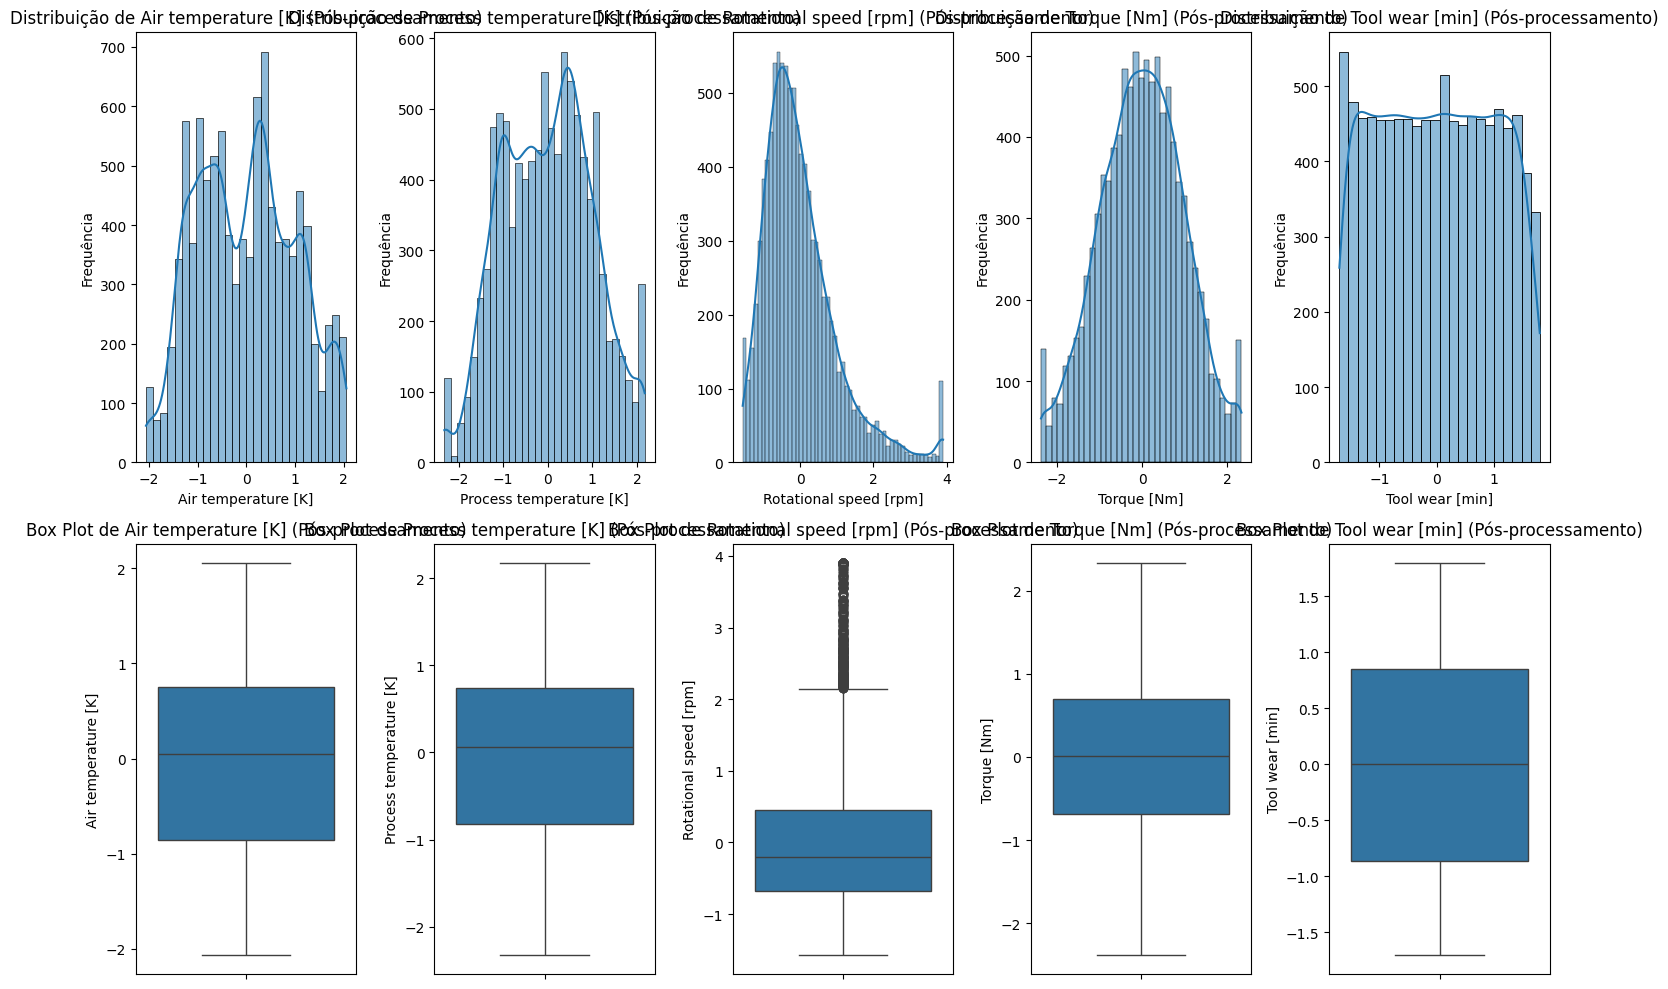

In [11]:
print("\n--- Novas Visualizações (Histogramas e Box Plots) após Pré-processamento ---")

# Colunas numéricas após o scaling
scaled_numerical_cols = [col for col in numerical_cols if col in df_final.columns]

plt.figure(figsize=(15, 10))
for i, col in enumerate(scaled_numerical_cols):
    # Histograma
    plt.subplot(2, len(scaled_numerical_cols), i + 1)
    sns.histplot(df_final[col], kde=True)
    plt.title(f'Distribuição de {col} (Pós-processamento)')
    plt.xlabel(col)
    plt.ylabel('Frequência')

    # Box Plot
    plt.subplot(2, len(scaled_numerical_cols), i + 1 + len(scaled_numerical_cols))
    sns.boxplot(y=df_final[col])
    plt.title(f'Box Plot de {col} (Pós-processamento)')
    plt.ylabel(col)
plt.tight_layout()
plt.show()

# Conclusão sobre a Importância e os Desafios do Pré-processamento de Dados da Indústria 4.0
O pré-processamento de dados é uma etapa fundamental e não negociável em qualquer projeto de Machine Learning, especialmente no contexto da Indústria 4.0 e manutenção preditiva.

## Importância:

Qualidade do Modelo: Modelos de ML são tão bons quanto os dados que os alimentam. Dados brutos, com ruídos, outliers ou em formatos inadequados, podem levar a modelos ineficazes, com baixo desempenho e conclusões erradas. O pré-processamento garante que o modelo esteja aprendendo com dados limpos e relevantes.

Eficiência do Treinamento: A padronização de dados, por exemplo, acelera a convergência de algoritmos de otimização, tornando o treinamento mais rápido e eficiente.

Interpretabilidade: Dados bem preparados podem levar a modelos mais interpretáveis, onde a influência de cada feature é mais clara.

Desempenho Otimizado: Técnicas como o tratamento de outliers e a codificação categórica garantem que o modelo não seja enganado por anomalias ou por uma interpretação incorreta de dados não numéricos.

## Desafios na Indústria 4.0:

Volume e Velocidade dos Dados: Sensores em ambientes industriais geram um volume massivo de dados em alta velocidade (telemetria em tempo real). Processar isso de forma eficiente é um desafio computacional.

Ruído e Inconsistências: Dados de sensores podem ser ruidosos, incompletos ou inconsistentes devido a falhas de hardware, calibração incorreta ou transmissão de dados. A identificação e tratamento desses problemas exige robustez.

Natureza dos Outliers: Em manutenção preditiva, os outliers (ex: picos de temperatura, vibração) podem ser indicadores cruciais de uma falha iminente. Distinguir outliers genuínos de erros de dados é um desafio que requer conhecimento do domínio.

Variedade de Tipos de Dados: Dados da Indústria 4.0 podem vir em múltiplos formatos (séries temporais, dados categóricos, imagens, etc.), exigindo uma gama diversificada de técnicas de pré-processamento.

Desequilíbrio de Classes: Como vimos no dataset, falhas são eventos raros. Isso cria um grande desequilíbrio entre as classes "sem falha" e "com falha", o que é um desafio significativo na modelagem e pré-processamento, exigindo técnicas como oversampling ou undersampling (que seriam exploradas em etapas futuras do projeto).

Em suma, o pré-processamento é a base para a construção de sistemas de manutenção preditiva robustos e confiáveis na Indústria 4.0, permitindo que as empresas otimizem operações, evitem paradas não programadas e garantam a segurança.